In [11]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

#  Connecting to the Database


In [12]:
load_dotenv()

db_type = os.getenv('DB_TYPE')
db_driver = os.getenv('DB_DRIVER')
username = os.getenv('DB_USERNAME')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
dbname = os.getenv('DB_NAME')


connection_string = f"{db_type}+{db_driver}://{username}:{password}@{host}:{port}/{dbname}"
engine = create_engine(connection_string)


# Loading Data into DataFrames

In [13]:
try:
    with engine.connect() as connection:
        trashevent_query = "SELECT * FROM kitro_trashevent_new"
        trashevent_df = pd.read_sql(trashevent_query, engine)
        
        outlet_query = "SELECT * FROM kitro_outlet_new"
        outlet_df = pd.read_sql(outlet_query, engine)
        
        property_query = "SELECT * FROM kitro_property_new"
        property_df = pd.read_sql(property_query, engine)
        
        customer_query = "SELECT * FROM kitro_customer_new"
        customer_df = pd.read_sql(customer_query, engine)
        
        deployment_query = "SELECT * FROM kitro_deployment_new"
        deployment_df = pd.read_sql(deployment_query, engine)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    engine.dispose()


# Inspecting the Tables

In [14]:
print("Trashevent Table:")
print(trashevent_df.head())

print("\nDeployment Table:")
print(deployment_df.head())

print("\nOutlet Table:")
print(outlet_df.head())

print("\nProperty Table:")
print(property_df.head())

print("\nCustomer Table:")
print(customer_df.head())

print("\nTrashevent Table Columns:")
print(trashevent_df.info())

print("\nDeployment Table Columns:")
print(deployment_df.info())

print("\nOutlet Table Columns:")
print(outlet_df.info())

print("\nProperty Table Columns:")
print(property_df.info())

print("\nCustomer Table Columns:")
print(customer_df.info())


Trashevent Table:
   id            datetime  weight                      image_id  \
0   1 2020-08-26 11:33:40      40  4044/2020-08-26-11-33-40.jpg   
1   2 2020-09-21 07:52:53      80  4044/2020-09-21-07-52-53.jpg   
2   3 2020-03-04 18:27:04      90  4044/2020-03-04-18-27-04.jpg   
3   4 2020-09-03 18:11:00      50  4044/2020-09-03-18-11-00.jpg   
4   5 2020-09-17 12:26:23     140  4044/2020-09-17-12-26-23.jpg   

                                                data  device_id  outlet_id  
0  {'seq': '2008', 'etag': '"ee2cfb77ea0deb1d46ec...       4044          1  
1  {'seq': '3577', 'etag': '"f6eb563625318d0e7718...       4044          1  
2  {'seq': '975', 'etag': '"9c7ae98dcab7ebd827f2f...       4044          1  
3  {'seq': '2688', 'etag': '"630d292972efe236c6ca...       4044          1  
4  {'seq': '3457', 'etag': '"36680ce28f1f4c7d8da9...       4044          1  

Deployment Table:
   id  device_id  outlet_id        installed_on          start_date  \
0   1       4044          1

# Metrics

## Average number of trashevents per device and per day

In [15]:
trashevent_df['datetime'] = pd.to_datetime(trashevent_df['datetime'])

trashevent_df['date'] = trashevent_df['datetime'].dt.date

device_trashevent_counts = trashevent_df.groupby('device_id').size()
avg_trashevents_per_device = device_trashevent_counts.mean()

daily_trashevent_counts = trashevent_df.groupby('date').size()
avg_trashevents_per_day = daily_trashevent_counts.mean()

print("Average number of trashevents per device:", avg_trashevents_per_device)
print("Average number of trashevents per day:", avg_trashevents_per_day)


Average number of trashevents per device: 106228.82352941176
Average number of trashevents per day: 1574.4463818657366


## Customer with the most total weight of food waste measured and the total weight measured for this customer

In [16]:
trashevent_outlet = trashevent_df.merge(outlet_df, left_on='outlet_id', right_on='id', how='left', suffixes=('', '_outlet'))

trashevent_property = trashevent_outlet.merge(property_df, left_on='property_id', right_on='id', how='left', suffixes=('', '_property'))

trashevent_customer = trashevent_property.merge(customer_df, left_on='customer_id', right_on='id', how='left', suffixes=('', '_customer'))

customer_weight = trashevent_customer.groupby('customer_name')['weight'].sum().reset_index()
customer_weight = customer_weight.sort_values(by='weight', ascending=False).reset_index(drop=True)

top_customer = customer_weight.iloc[0]
print(f"Customer with the most total weight of food waste: {top_customer['customer_name']}, Total weight measured for this customer : {top_customer['weight']}")


Customer with the most total weight of food waste: KITRO SA, Total weight measured for this customer : 226755140


## The calendar month (over all years) with the most trashevents captured and the number of trashevents for this calendar month

In [17]:
trashevent_df['year_month'] = trashevent_df['datetime'].dt.to_period('M')
month_trashevents = trashevent_df.groupby('year_month').size().reset_index(name='count')

top_month = month_trashevents.sort_values(by='count', ascending=False).iloc[0]
print(f"Calendar month with the most trashevents: {top_month['year_month']}, Number of trashevents for this calendar month: {top_month['count']}")


Calendar month with the most trashevents: 2020-09, Number of trashevents for this calendar month: 79022


# Visuals

## Evolution of total weight measured per day


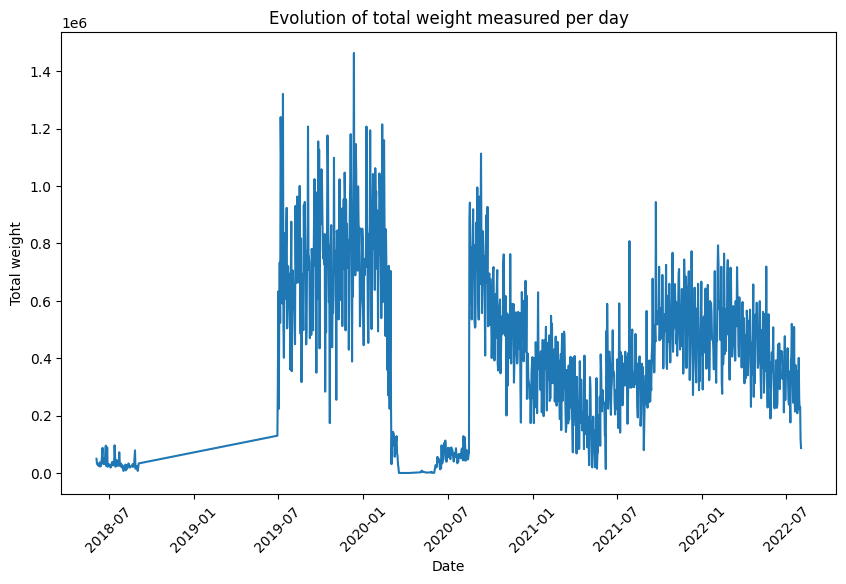

In [18]:
weight_per_day = trashevent_df.groupby('date')['weight'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=weight_per_day, x='date', y='weight')
plt.title('Evolution of total weight measured per day')
plt.xlabel('Date')
plt.ylabel('Total weight')
plt.xticks(rotation=45)
plt.show()


## Number of active deployments per property


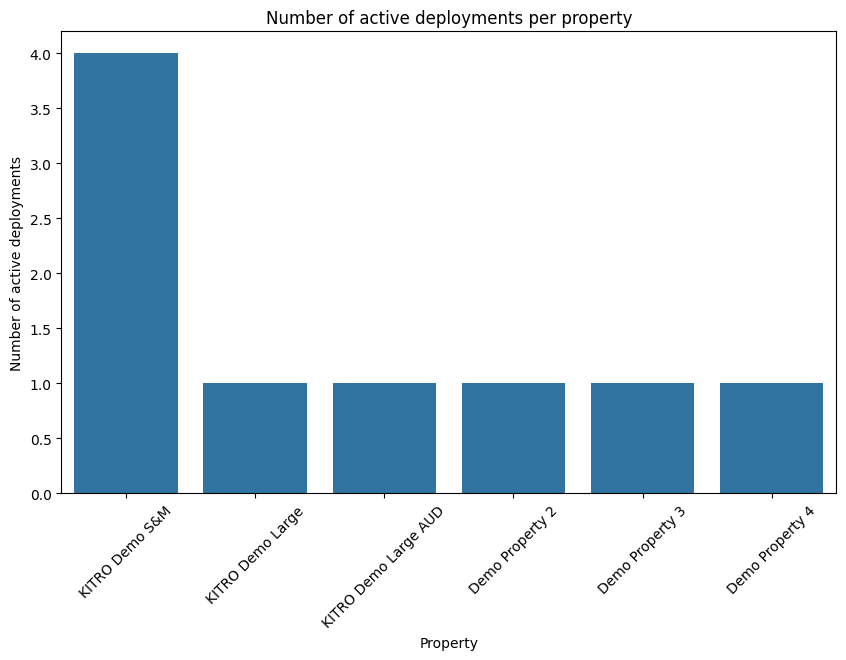

In [19]:
today = pd.to_datetime('today').normalize()
active_deployments = deployment_df[(deployment_df['start_date'] <= today) & (deployment_df['end_date'] >= today)]

active_deployments_property = active_deployments.merge(outlet_df, left_on='outlet_id', right_on='id', how='left')

deployments_per_property = active_deployments_property.groupby('property_id').size().reset_index(name='count')

deployments_per_property = deployments_per_property.merge(property_df, left_on='property_id', right_on='id', how='left')

plt.figure(figsize=(10, 6))
sns.barplot(data=deployments_per_property, x='property_name', y='count')
plt.title('Number of active deployments per property')
plt.xlabel('Property')
plt.ylabel('Number of active deployments')
plt.xticks(rotation=45)
plt.show()


## Daily average weight of food waste per device

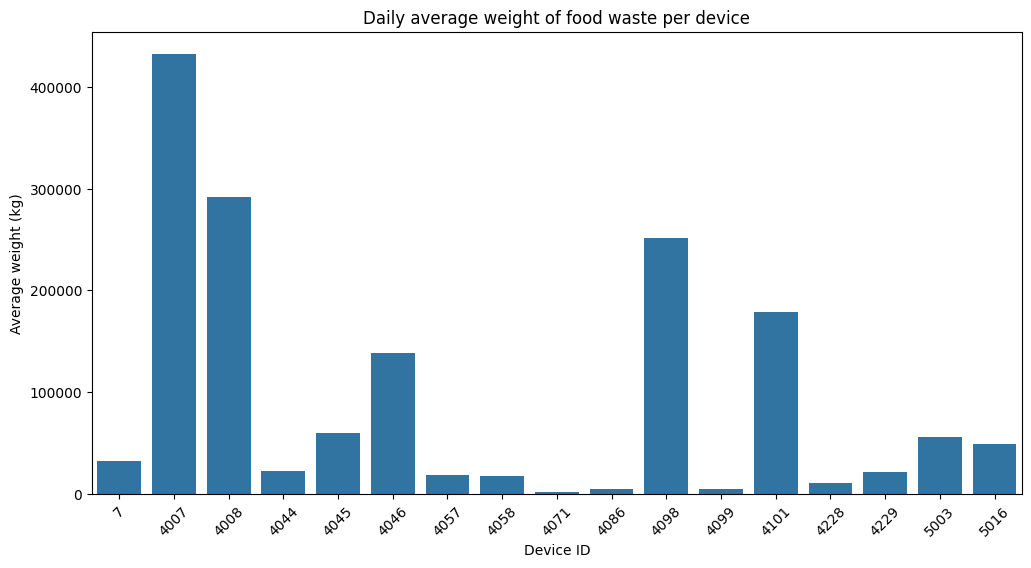

In [20]:
trashevent_df['datetime'] = pd.to_datetime(trashevent_df['datetime'])

daily_weight_per_device = trashevent_df.groupby(['device_id', trashevent_df['datetime'].dt.date])['weight'].sum().reset_index()

daily_average_weight_per_device = daily_weight_per_device.groupby('device_id')['weight'].mean().reset_index(name='avg_weight')

plt.figure(figsize=(12, 6))
sns.barplot(data=daily_average_weight_per_device, x='device_id', y='avg_weight')
plt.title('Daily average weight of food waste per device')
plt.xlabel('Device ID')
plt.ylabel('Average weight (kg)')
plt.xticks(rotation=45)
plt.show()